 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Séance 2, Notebook 2 : Projected Quantum Features</h2>
</div>
    
    

### Objectifs du notebook
    
Ce notebook vise à introduire les techniques de tomographie généralement utilisées pour projeter l'état quantique et accélérer ainsi les calculs liés à l'exécution des algorithmes quantiques.
    
### Imports
    
Le notebook, comme la plupart des applications qui seront décrites dans ce module, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

Les librairies suivantes sont également requises pour les applications proposées ici :
- *scikit-learn* : pour l'implémentation et l'exécution des modèles de machine learning (ici le SVM)
- *numpy* : pour la récupération du dataset
- *matplotlib* : pour la visualisation des données

In [49]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator

from sklearn.svm import SVC

import numpy as np
import time

import matplotlib.pyplot as plt

## 1. Chargement et visualisation des données

In [50]:
data_archive=np.load("data.npz")

X_train=data_archive["X_train"]
X_test=data_archive["X_test"]
y_train=data_archive["y_train"]
y_test=data_archive["y_test"]

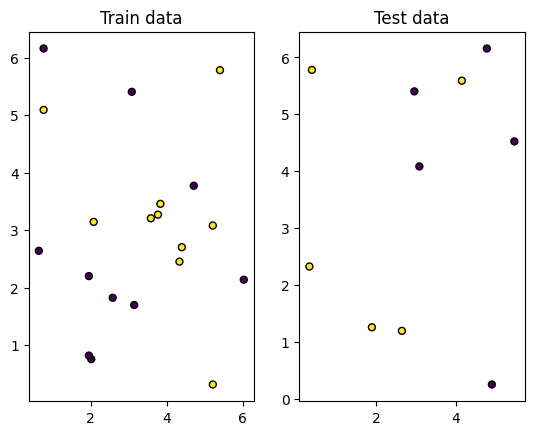

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, s=25, edgecolor="k")
ax1.title.set_text('Train data')
ax2.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test, s=25, edgecolor="k")
ax2.title.set_text('Test data')

## 2. Definition d'un Classifieur SVM classique

On cherche à entraîner une machine à vecteurs de support (SVM). On peut [retrouver ici une explication de la théorie des SVM](https://fr.wikipedia.org/wiki/Machine_%C3%A0_vecteurs_de_support).
L'élément central à retenir est que pour s'entrainer sur une tâche de classification, un SVM n'a besoin que de deux éléments :
 - la connaissance des **labels réels** des points de données du jeu d'entraînement
 - une matrice (nommée matrice de Gram ou matrice noyau) contenant **l'ensemble des produits scalaires entre tous les points de données**, pris deux à deux.
 
On commence par définir la fonction qui nous permet de calculer le produit scalaire entre deux vecteurs de données :

In [52]:
def scalar_product(x,y):
    return(np.dot(x,y))

La fonction utilitaire ci dessous, **qui sera réutilisée plusieurs fois dans cette séance**, permet de calculer la matrice noyau entre deux séries de points (X et Y), en utilisant la fopnction $kernel_function$ pour calculer chaque élément (pour le SVM classique, nous utiliserons donc le produit scalaire)

In [53]:
def compute_kernel(X,Y,kernel_function):
    start=time.time()
    ## Calcul de la matrice de Gram classique
    #initialisation de la matrice de Gram
    gram=np.ones((np.shape(X)[0],np.shape(Y)[0]))
    #Remplissage de la matrice de Gram
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            gram[i,j]=kernel_function(x,y)
    end=time.time()
    print("Time required to compute kernel : {} s".format(end-start))
    return(gram)

Pour entraîner le SVM, on calcule la mtrice noyau contenant les produits scalaires de tous les éléments de $X_train$ pris deux à deux :

Time required to compute kernel : 0.005398273468017578 s


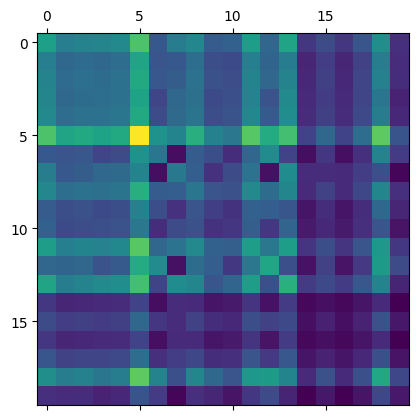

In [54]:
classical_kernel = compute_kernel(X_train,X_train,scalar_product)

plt.matshow(classical_kernel)

L'entraînement se fait en provisionant la matrice noyau et les labels d'entrainement ($y_train$)

In [55]:
classical_svm=SVC(kernel="precomputed")

classical_svm.fit(classical_kernel,y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'precomputed'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [56]:
print("Accuracy Train : {}".format(classical_svm.score(classical_kernel,y_train)))

Accuracy Train : 0.75


Pour le test, le SVM nécessite une matrice noyau contenant les produits scalaires des éléments de $X_test$ et $X_train$ pris deux à deux :

Time required to compute kernel : 0.002013683319091797 s


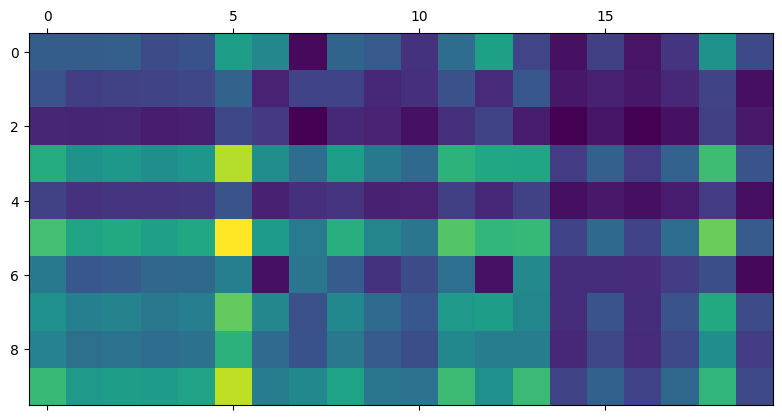

In [57]:
test_kernel = compute_kernel(X_test,X_train,scalar_product)

plt.matshow(test_kernel)

In [58]:
print("Accuracy Test : {}".format(classical_svm.score(test_kernel,y_test)))

Accuracy Test : 0.1


## 3. Calcul des features quantiques projetées

Comme pour le QSVM, on choisit **d'encoder le vecteur $x$ dans un état quantique, plutôt que d'utiliser sa valeur directement**

Toutefois, pour éviter l'exécution de cacluls trop couteux, on choisit de projeter l'état $U(x)|0⟩$ pour en estimer les coordonnées. On pourra alors utiliser ces coordonnées comme nouvelle représentation du vecteur $x$


<div class="alert alert-block alert-info">
<ul>
    <li>Implémenter une fonction prenant en entrée le vecteur $x$, et renvoyant un circuit correspondant à l'état $U(x)|0⟩$ (utilisez l'unitaire de votre choix)
    <li>Visualiser son bon fonctionnement en dessinant le circuit en utilisant le premier point de données de X_train
</ul>
</div>

In [59]:

def circ(x):
    qc=QuantumCircuit(2)     
    qc.h([0,1])
    qc.rz(np.pi*x[0],0)
    qc.rz(np.pi*x[1],1)
    qc.cx(0,1)
    qc.rz(-np.pi*x[0],0)
    qc.rz(-np.pi*x[1],1)
    return(qc)


qc=circ(X_train[0])
print(qc.draw())

     ┌───┐┌────────────┐     ┌─────────────┐
q_0: ┤ H ├┤ Rz(16.384) ├──■──┤ Rz(-16.384) ├
     ├───┤├────────────┤┌─┴─┐├─────────────┤
q_1: ┤ H ├┤ Rz(9.6722) ├┤ X ├┤ Rz(-9.6722) ├
     └───┘└────────────┘└───┘└─────────────┘



<div class="alert alert-block alert-info">
<ul>
    <li>Implémenter une fonction permettant de cacluler les projections du vecteur d'état précédemment définit, en utilisant les observables $IX,IY,IZ,XI,YI,ZI$ et en exécutant le circuit quantique à l'aide d'un Estimator
</ul>
</div>

In [74]:
Observables=['IX','IY','IZ','XI','YI','ZI']
pass_manager = generate_preset_pass_manager(1, AerSimulator())
def get_expectation_value(X):
    X_redi=[]
    for x in X:
        isa_qc=pass_manager.run(circ(x))
        estimator=Estimator()
        job=estimator.run([(isa_qc, Observables[i]) for i in range(len(Observables))])
        result=job.result()
        X_redi.append([result[i].data.evs.item() for i in range(len(Observables))])
    return(X_redi)

<div class="alert alert-block alert-info">
<ul>
    <li>Transformer les données $X_train$ et $X_test$ en calculant leurs features projetées
    <li>Entraîner et tester un SVM classique sur ces nouvelles features.
</ul>
</div>

In [75]:
X_train_projected = get_expectation_value(X_train)

X_test_projected = get_expectation_value(X_test)

Time required to compute kernel : 0.0020008087158203125 s


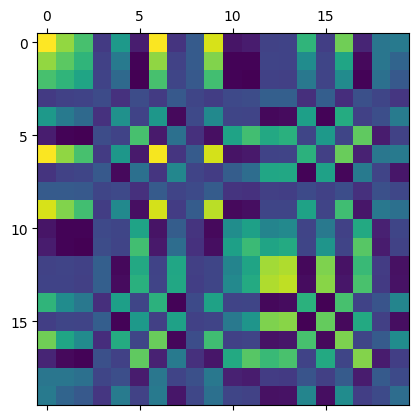

In [76]:
quantum_kernel = compute_kernel(X_train_projected ,X_train_projected, scalar_product)
plt.matshow(quantum_kernel)


In [77]:
quantum_svm=SVC(kernel="precomputed")
quantum_svm.fit(quantum_kernel,y_train)
print("Accuracy Train : {}".format(quantum_svm.score(quantum_kernel,y_train)))

Accuracy Train : 0.7


Time required to compute kernel : 0.0007412433624267578 s
Accuracy Test : 0.1


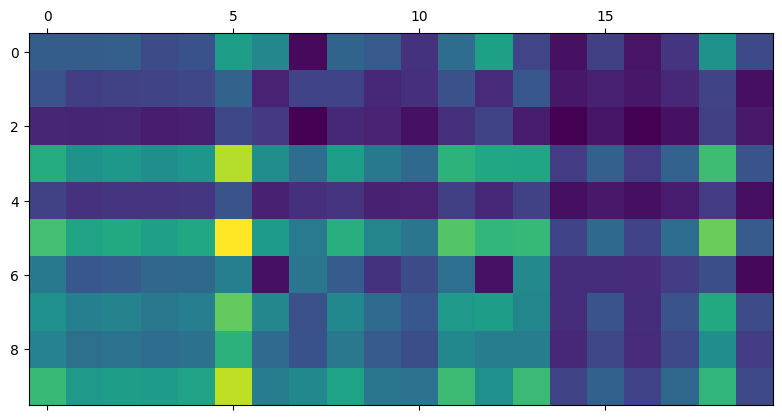

In [78]:
test_kernel = compute_kernel(X_test,X_train,scalar_product)

plt.matshow(test_kernel)

print("Accuracy Test : {}".format(classical_svm.score(test_kernel,y_test)))